In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
import matplotlib.pylab as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Dense, Input, Dropout
from keras._tf_keras.keras.regularizers import l2

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
df0 = pd.read_csv('ETH-USD.csv', index_col=0, parse_dates=True)

In [3]:
df = df0[['Close']].copy()

In [4]:
df['LogClose'] = np.log(df['Close'])

In [5]:
df['DiffLogClose'] = df['LogClose'].diff()

In [6]:
def build_model(units=50, optimizer='adam', activation='relu',dropout_rate=0.2, regularization_rate=0.01):
    i = Input(shape=(T,))
    x = Dense(units, activation=activation)(i)  
    x = Dropout(dropout_rate)(x)  
    x = Dense(units, activation=activation, kernel_regularizer=l2(regularization_rate))(x)  
    x = Dense(1)(x) 
    model = Model(inputs=i, outputs=x)
    model.compile(loss='mape', optimizer=optimizer)
    return model

In [7]:
param_grid = {
    'model__units': [32, 64],  
    'model__activation': ['relu', 'tanh'],  
    'model__optimizer': ['adam', 'rmsprop'],  
    'model__dropout_rate': [0.1, 0.2], 
    'model__regularization_rate': [0.01, 0.001], 
    'epochs': [50, 100],
}

1 . time going trough
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/50
10/10 - 4s - 409ms/step - loss: 504.0325 - val_loss: 99.7128
Epoch 2/50
10/10 - 0s - 13ms/step - loss: 431.4760 - val_loss: 116.9802
Epoch 3/50
10/10 - 0s - 13ms/step - loss: 362.5929 - val_loss: 87.9955
Epoch 4/50
10/10 - 0s - 11ms/step - loss: 440.0880 - val_loss: 108.1108
Epoch 5/50
10/10 - 0s - 12ms/step - loss: 524.7747 - val_loss: 103.6071
Epoch 6/50
10/10 - 0s - 11ms/step - loss: 400.5482 - val_loss: 89.3359
Epoch 7/50
10/10 - 0s - 13ms/step - loss: 530.2192 - val_loss: 97.6156
Epoch 8/50
10/10 - 0s - 13ms/step - loss: 296.2277 - val_loss: 91.2115
Epoch 9/50
10/10 - 0s - 13ms/step - loss: 692.5443 - val_loss: 102.0268
Epoch 10/50
10/10 - 0s - 11ms/step - loss: 251.2351 - val_loss: 121.2536
Epoch 11/50
10/10 - 0s - 11ms/step - loss: 640.2229 - val_loss: 87.3371
Epoch 12/50
10/10 - 0s - 13ms/step - loss: 435.2349 - val_loss: 110.0210
Epoch 13/50
10/10 - 0s - 11ms/step - loss: 485.7232 - 

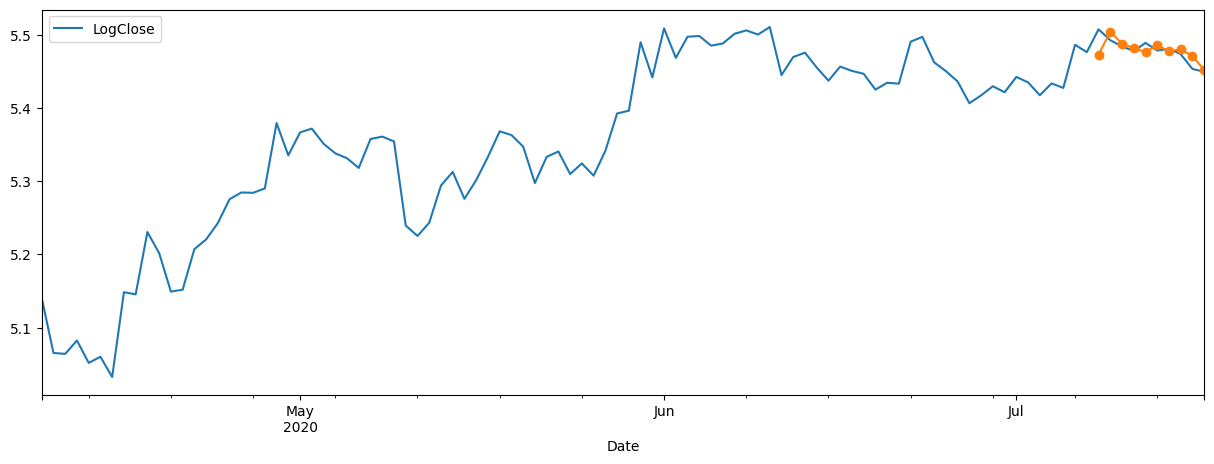

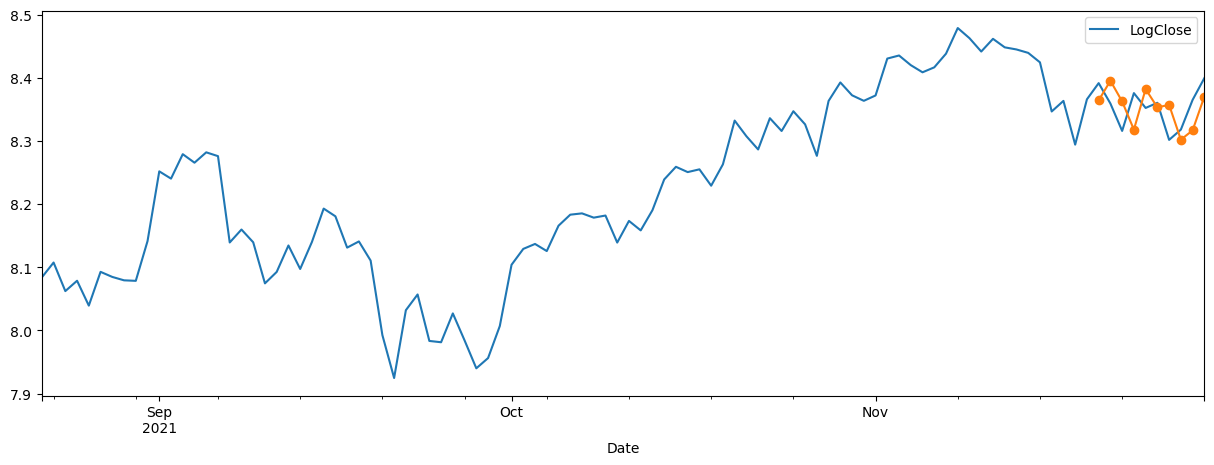

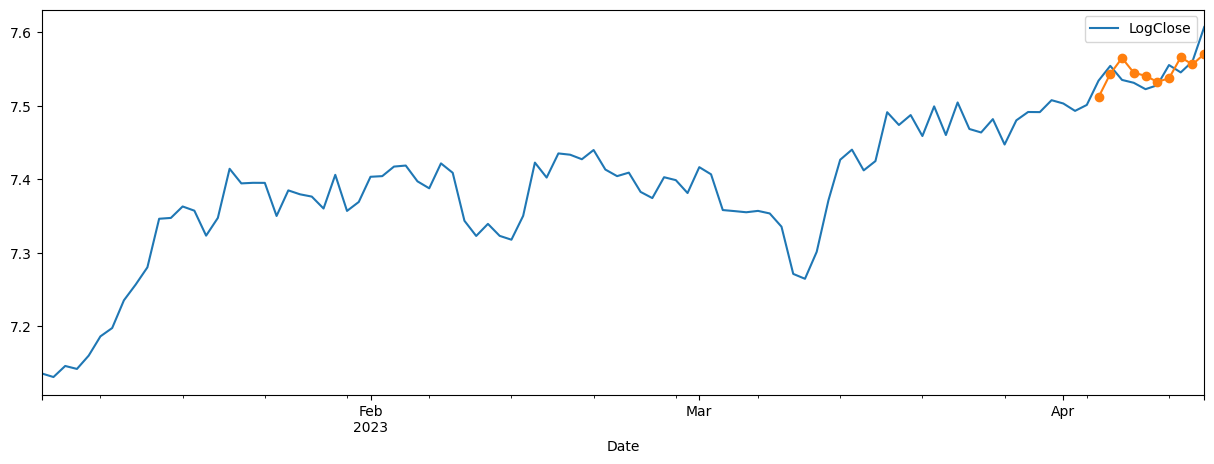

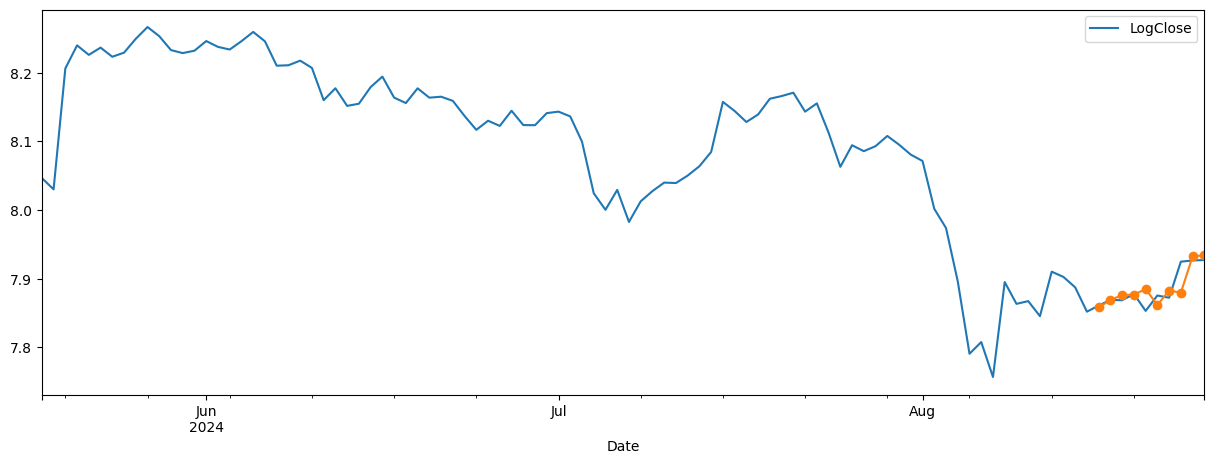

In [19]:
i = 328
real_10d = []
predicted_10d = []
c = 1
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    T = 10
    X = []
    Y = []
    for t in range(len(series) - T):
        x = series[t:t + T]
        X.append(x)
        y = series[t + T]
        Y.append(y)
    X = np.array(X).reshape(-1,T)
    Y = np.array(Y)
    
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xtest, Ytest = X[-Ntest:], Y[-Ntest:]
    
    print(c,'. time going trough')
    
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain, Ytrain,validation_data=(Xtest, Ytest))
    best_model = grid_result.best_estimator_
    
    train_idx[:T+1] = False
    
    Ptest = best_model.predict(Xtest)
    
    Ptest = scaler.inverse_transform([Ptest]).flatten()
    
    temp.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest
    
    temp['ShiftLogClose'] = temp['LogClose'].shift(1)
    prev = temp['ShiftLogClose']
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'1step_test']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, '1step_test'], marker='o')
    
    predicted_10d.append(predicted_temp)
    real_10d.append(real_temp)
    c = c + 1

1 . time going trough
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
9/9 - 2s - 184ms/step - loss: 1114.1888 - val_loss: 303.7814
Epoch 2/100
9/9 - 0s - 14ms/step - loss: 966.9908 - val_loss: 282.5883
Epoch 3/100
9/9 - 0s - 14ms/step - loss: 827.5369 - val_loss: 279.1317
Epoch 4/100
9/9 - 0s - 14ms/step - loss: 620.0567 - val_loss: 260.7202
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 670.3047 - val_loss: 239.7643
Epoch 6/100
9/9 - 0s - 14ms/step - loss: 752.2581 - val_loss: 247.3655
Epoch 7/100
9/9 - 0s - 16ms/step - loss: 471.7411 - val_loss: 240.3215
Epoch 8/100
9/9 - 0s - 14ms/step - loss: 686.6206 - val_loss: 222.3774
Epoch 9/100
9/9 - 0s - 16ms/step - loss: 838.8581 - val_loss: 204.5301
Epoch 10/100
9/9 - 0s - 14ms/step - loss: 1080.6783 - val_loss: 180.7868
Epoch 11/100
9/9 - 0s - 16ms/step - loss: 367.7350 - val_loss: 193.6127
Epoch 12/100
9/9 - 0s - 17ms/step - loss: 544.6202 - val_loss: 196.1339
Epoch 13/100
9/9 - 0s - 16ms/step - loss: 562.4384 - val_l

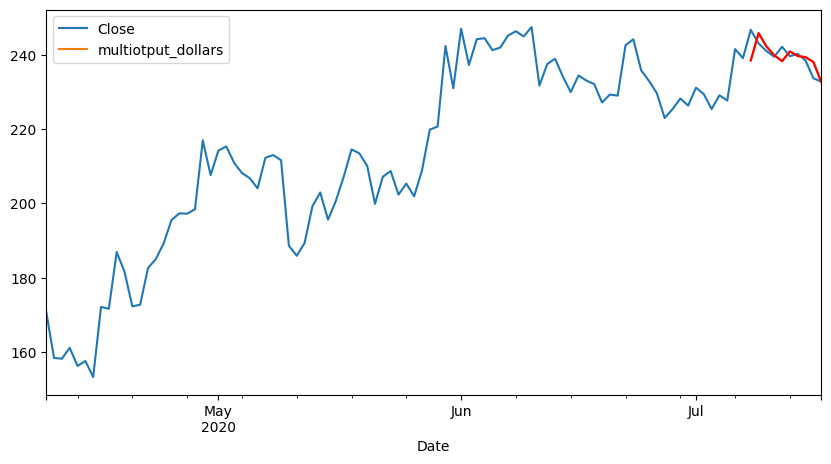

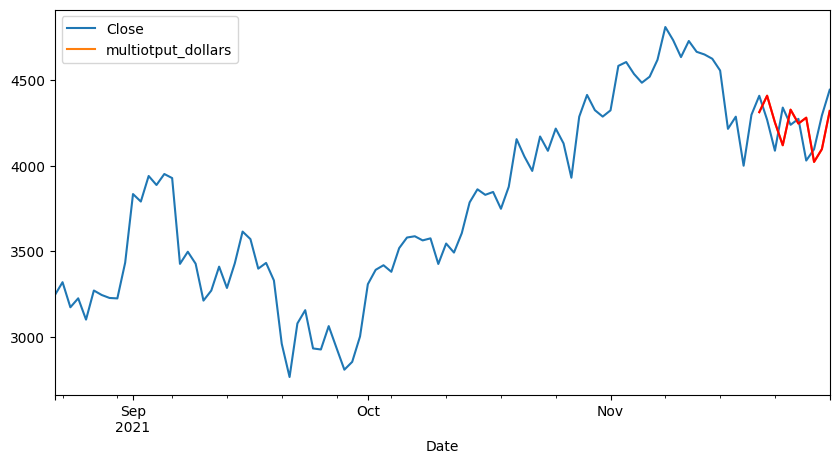

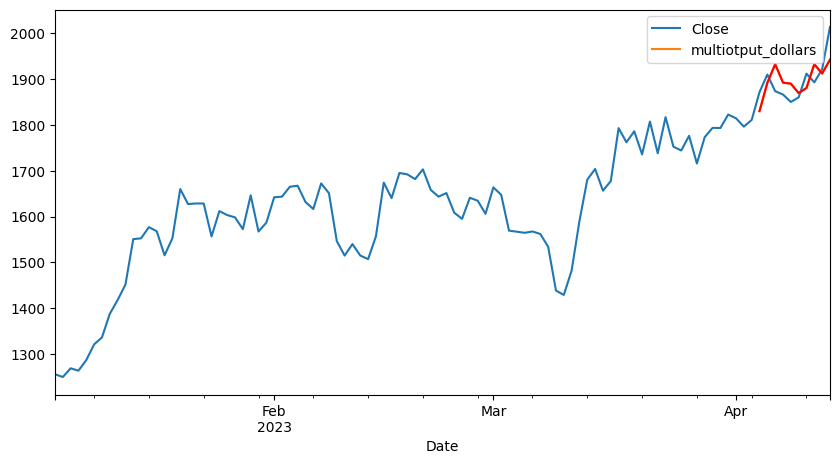

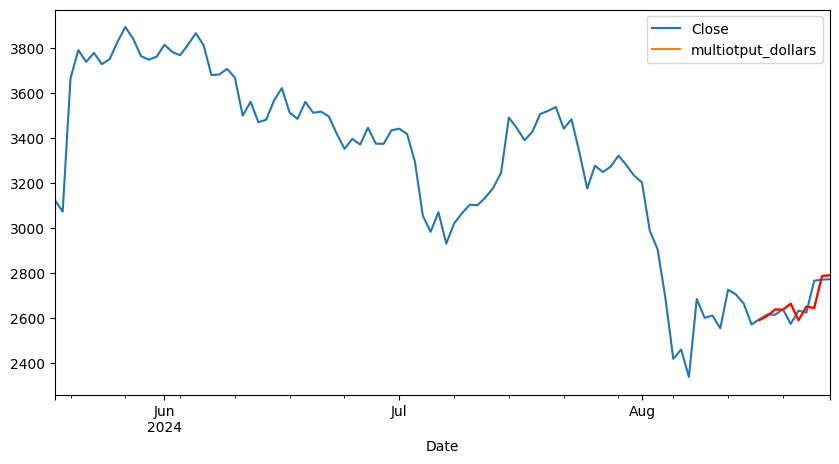

In [8]:
i = 328
real_50d = []
predicted_50d = []
c = 1
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    T = 50
    X = []
    Y = []
    for t in range(len(series) - T):
        x = series[t:t + T]
        X.append(x)
        y = series[t + T]
        Y.append(y)
    X = np.array(X).reshape(-1,T)
    Y = np.array(Y)
    
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xtest, Ytest = X[-Ntest:], Y[-Ntest:]
    
    print(c,'. time going trough')
    
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain, Ytrain,validation_data=(Xtest, Ytest))
    best_model = grid_result.best_estimator_
    
    train_idx[:T+1] = False
    
    Ptest = best_model.predict(Xtest)
    
    Ptest = scaler.inverse_transform([Ptest]).flatten()
    
    temp.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest
    
    temp['ShiftLogClose'] = temp['LogClose'].shift(1)
    prev = temp['ShiftLogClose']
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'1step_test']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.loc[test_idx, 'multiotput_dollars'] = predicted_temp
    
    temp.iloc[-100:][['Close', 'multiotput_dollars']].plot(figsize=(10, 5))
    plt.plot(temp.loc[test_idx, 'multiotput_dollars'],color='red')
    plt.legend()
    
    predicted_50d.append(predicted_temp)
    real_50d.append(real_temp)
    c = c + 1

1 . time going trough
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
7/7 - 1s - 173ms/step - loss: 1070.6490 - val_loss: 216.7206
Epoch 2/100
7/7 - 0s - 10ms/step - loss: 887.9749 - val_loss: 196.8939
Epoch 3/100
7/7 - 0s - 9ms/step - loss: 565.8965 - val_loss: 183.1645
Epoch 4/100
7/7 - 0s - 11ms/step - loss: 1141.4254 - val_loss: 178.6689
Epoch 5/100
7/7 - 0s - 9ms/step - loss: 1105.7729 - val_loss: 175.1311
Epoch 6/100
7/7 - 0s - 10ms/step - loss: 635.4833 - val_loss: 175.5506
Epoch 7/100
7/7 - 0s - 10ms/step - loss: 1270.3070 - val_loss: 176.5629
Epoch 8/100
7/7 - 0s - 11ms/step - loss: 1296.4607 - val_loss: 160.8270
Epoch 9/100
7/7 - 0s - 11ms/step - loss: 385.9868 - val_loss: 144.9943
Epoch 10/100
7/7 - 0s - 10ms/step - loss: 539.9160 - val_loss: 133.7968
Epoch 11/100
7/7 - 0s - 10ms/step - loss: 1256.3496 - val_loss: 127.9547
Epoch 12/100
7/7 - 0s - 10ms/step - loss: 783.6978 - val_loss: 120.9202
Epoch 13/100
7/7 - 0s - 10ms/step - loss: 870.2273 - val

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
39/39 - 1s - 23ms/step - loss: 946.0212 - val_loss: 104.1702
Epoch 2/100
39/39 - 0s - 3ms/step - loss: 720.2326 - val_loss: 83.5913
Epoch 3/100
39/39 - 0s - 3ms/step - loss: 1161.7422 - val_loss: 93.7025
Epoch 4/100
39/39 - 0s - 3ms/step - loss: 889.5016 - val_loss: 92.6075
Epoch 5/100
39/39 - 0s - 3ms/step - loss: 750.6353 - val_loss: 101.0277
Epoch 6/100
39/39 - 0s - 3ms/step - loss: 582.1343 - val_loss: 100.5245
Epoch 7/100
39/39 - 0s - 3ms/step - loss: 902.7339 - val_loss: 82.4367
Epoch 8/100
39/39 - 0s - 3ms/step - loss: 558.2728 - val_loss: 82.2447
Epoch 9/100
39/39 - 0s - 3ms/step - loss: 746.2805 - val_loss: 87.1002
Epoch 10/100
39/39 - 0s - 3ms/step - loss: 511.5264 - val_loss: 100.8962
Epoch 11/100
39/39 - 0s - 3ms/step - loss: 873.1773 - val_loss: 87.6028
Epoch 12/100
39/39 - 0s - 3ms/step - loss: 352.3233 - val_loss: 76.0274
Epoch 13/100
39/39 - 0s - 3ms/step - loss: 1112.8387 - val_loss: 88.8062
Epoch 14/100
39/39 - 0s - 3ms/step - loss: 323.6023 - val_loss: 81

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
54/54 - 1s - 16ms/step - loss: 361.5069 - val_loss: 241.5294
Epoch 2/100
54/54 - 0s - 2ms/step - loss: 338.9243 - val_loss: 250.1738
Epoch 3/100
54/54 - 0s - 2ms/step - loss: 297.0238 - val_loss: 285.3169
Epoch 4/100
54/54 - 0s - 2ms/step - loss: 231.4169 - val_loss: 177.0362
Epoch 5/100
54/54 - 0s - 2ms/step - loss: 188.8440 - val_loss: 233.1905
Epoch 6/100
54/54 - 0s - 2ms/step - loss: 169.1606 - val_loss: 161.7310
Epoch 7/100
54/54 - 0s - 2ms/step - loss: 190.9206 - val_loss: 198.1203
Epoch 8/100
54/54 - 0s - 2ms/step - loss: 145.6879 - val_loss: 148.4685
Epoch 9/100
54/54 - 0s - 2ms/step - loss: 171.9878 - val_loss: 155.2247
Epoch 10/100
54/54 - 0s - 2ms/step - loss: 147.7423 - val_loss: 153.7877
Epoch 11/100
54/54 - 0s - 2ms/step - loss: 151.3011 - val_loss: 169.7885
Epoch 12/100
54/54 - 0s - 2ms/step - loss: 139.3337 - val_loss: 139.9384
Epoch 13/100
54/54 - 0s - 2ms/step - loss: 143.0493 - val_loss: 152.5059
Epoch 14/100
54/54 - 0s - 2ms/step - loss: 137.1200 - val_l

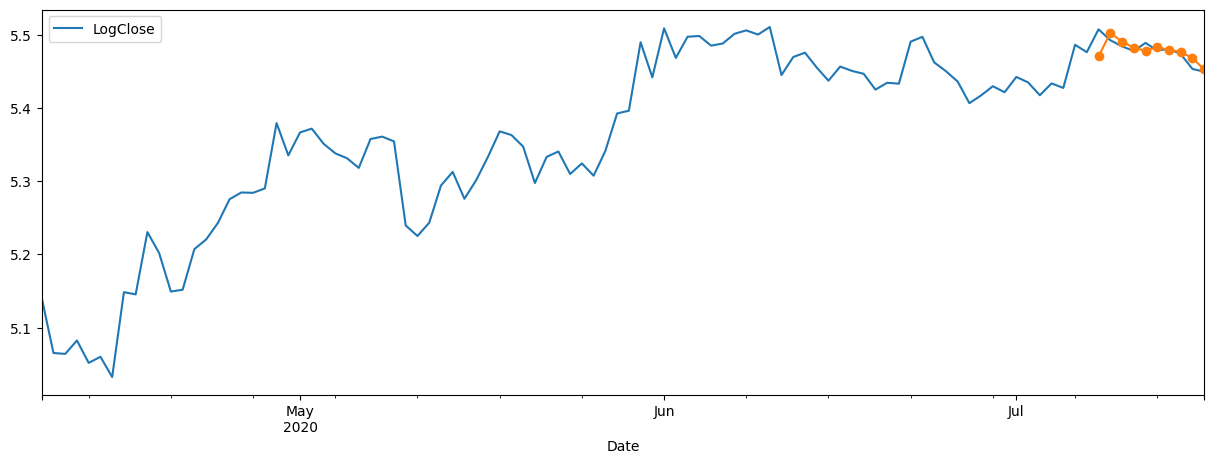

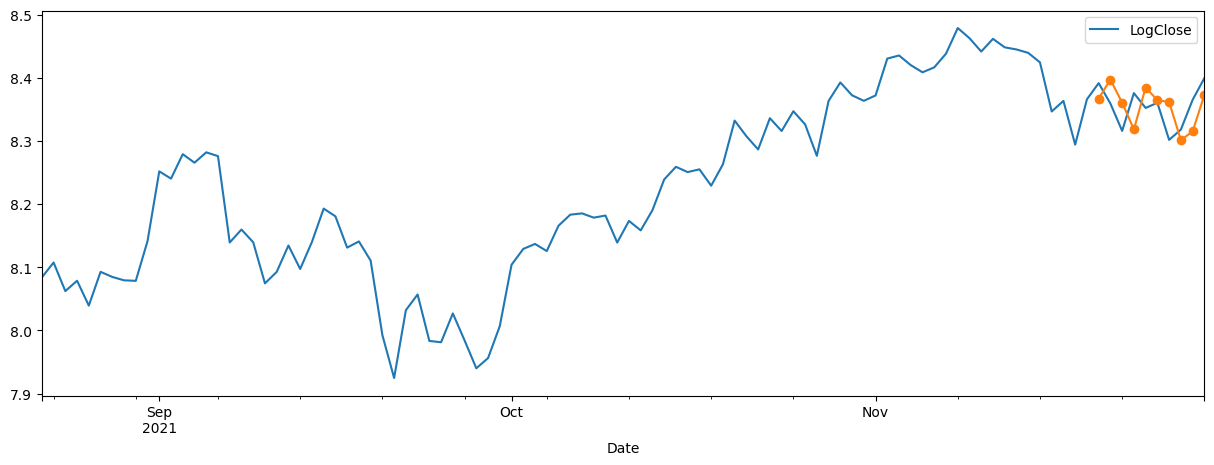

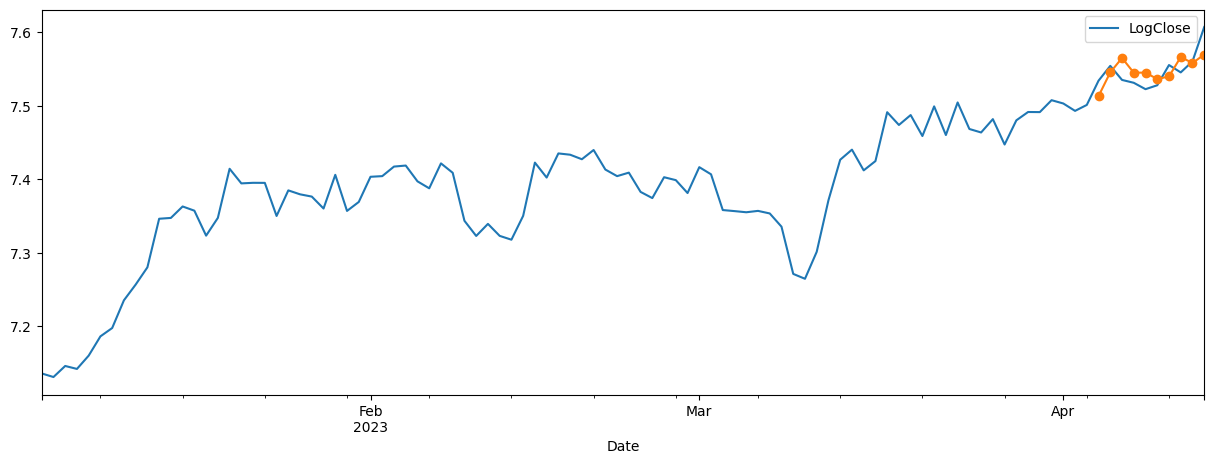

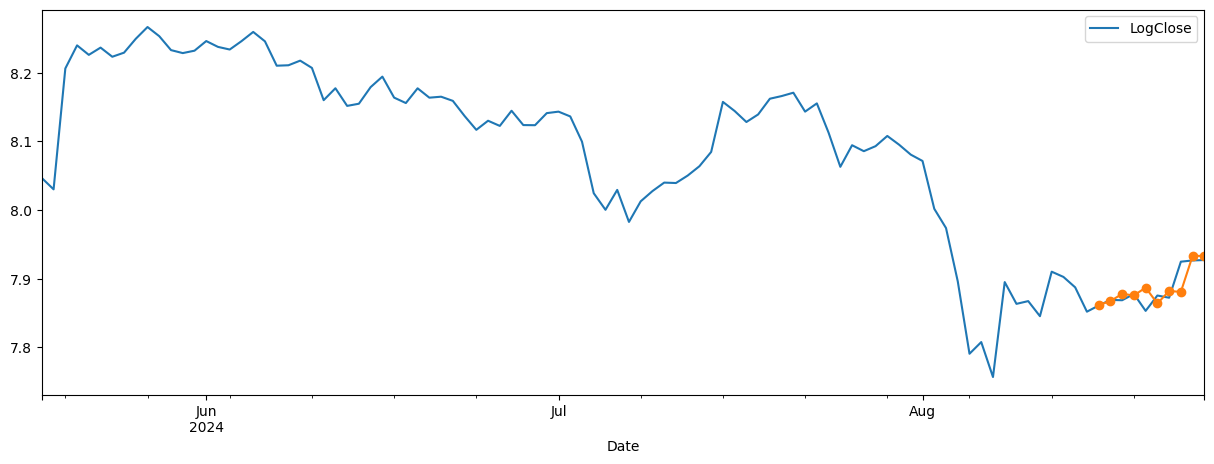

In [21]:
i = 328
real_100d = []
predicted_100d = []
c = 1
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 10
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    T = 100
    X = []
    Y = []
    for t in range(len(series) - T):
        x = series[t:t + T]
        X.append(x)
        y = series[t + T]
        Y.append(y)
    X = np.array(X).reshape(-1,T)
    Y = np.array(Y)
    
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xtest, Ytest = X[-Ntest:], Y[-Ntest:]
    
    print(c,'. time going trough')
    
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain, Ytrain,validation_data=(Xtest, Ytest))
    best_model = grid_result.best_estimator_
    
    train_idx[:T+1] = False
    
    Ptest = best_model.predict(Xtest)
    
    Ptest = scaler.inverse_transform([Ptest]).flatten()
    
    temp.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest
    
    temp['ShiftLogClose'] = temp['LogClose'].shift(1)
    prev = temp['ShiftLogClose']
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'1step_test']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, '1step_test'], marker='o')
    
    predicted_100d.append(predicted_temp)
    real_100d.append(real_temp)
    c = c + 1

In [22]:
print("R2 score for 10, 50 and 100 days are:",round(r2_score(real_10d, predicted_10d),4), round(r2_score(real_50d, predicted_50d),4),round(r2_score(real_100d, predicted_100d),4))

R2 score for 10, 50 and 100 days are: 0.9962 0.9964 0.9961


In [23]:
print("MAPE score for 10, 50 and 100 days are:",round(mean_absolute_percentage_error(real_10d, predicted_10d)*100,2),round(mean_absolute_percentage_error(real_50d, predicted_50d)*100,2),round(mean_absolute_percentage_error(real_100d, predicted_100d)*100,2))

MAPE score for 10, 50 and 100 days are: 1.9 1.86 1.89


In [24]:
print("MAE scores for 10, 50 and 100 days are:",round(mean_absolute_error(real_10d, predicted_10d),2),round(mean_absolute_error(real_50d, predicted_50d),2),round(mean_absolute_error(real_100d, predicted_100d),2))

MAE scores for 10, 50 and 100 days are: 55.02 53.15 55.1


In [25]:
print("MSE scores for 10, 50 and 100 days are:",round(mean_squared_error(real_10d, predicted_10d),2),round(mean_squared_error(real_50d, predicted_50d),2),round(mean_squared_error(real_100d, predicted_100d),2))

MSE scores for 10, 50 and 100 days are: 7714.65 7504.16 7929.27


In [26]:
print("RMSE scores for 10, 50 and 100 days are:",round(root_mean_squared_error(real_10d, predicted_10d),2),round(root_mean_squared_error(real_50d, predicted_50d),2),round(root_mean_squared_error(real_100d, predicted_100d),2))

RMSE scores for 10, 50 and 100 days are: 83.43 82.14 83.73
